Loading data

In [1]:
import os
import matplotlib.pyplot as plt
from esm.sdk.forge import ESM3ForgeInferenceClient
import numpy as np
from sklearn.model_selection import train_test_split
from utils.batch_embed import batch_embed
import pandas as pd
import seaborn as sns
import torch
from model.MLP_enzymes import MLP_enzymes
from model.random_forest_enzymes import random_forest_enzymes
from utils.evaluation_metrics import evaluation_metrics
from utils.load_fasta import load_fasta
from utils.train_mlp import train_mlp

# Path to ready data
ready_data_path = 'data/embeddings.csv'

# Check if there is ready data
if not os.path.exists(ready_data_path):
    # If there is no ready data preprocess it
    print(f"File {ready_data_path} not found, loading fasta")

    # Path to files
    path = 'data/'

    # Load FASTA files to Seq, limitations due to free api limit
    data = load_fasta(path, seq_limit=180, list_limit=80)

    # Initialize ESM-C client
    client = ESM3ForgeInferenceClient(model='esmc-300m-2024-12', url='https://forge.evolutionaryscale.ai', token=os.getenv('token'))

    # Create embeddings of every sequence
    data_embeddings = batch_embed(client, data['sequence'])

    embedding_float32 = [(embedding.to(torch.float32)).detach().numpy() for embedding in data_embeddings]
    final_data = pd.DataFrame(embedding_float32)

    data = data.drop(columns=['sequence'])

    final_data['EC'] = data['EC'].copy()
    print(final_data.info())

    final_data.to_csv(ready_data_path, index=False)

else:
    # if ready data found, just load it
    print(f"Found {ready_data_path}, loading it")
    final_data = pd.read_csv(ready_data_path)

# Split train and test data
x_train, x_test, y_train, y_test = train_test_split(final_data.iloc[:, 0:-1], final_data['EC'], test_size=0.2, random_state=42, stratify=final_data['EC'])

c:\Users\mateu\OneDrive\Pulpit\studia\ib\python\enzyme-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found data/embeddings.csv, loading it


Random Forest

In [2]:
# Create random forest model
model_random_forest = random_forest_enzymes(x_train, y_train)

# Predictions of random forest model
y_predict_rf = model_random_forest.predict(x_test)

# Calculate evaluation metrics of rf model
accuracy_rf, f1_rf, conf_matrix_rf = evaluation_metrics(y_test, y_predict_rf)

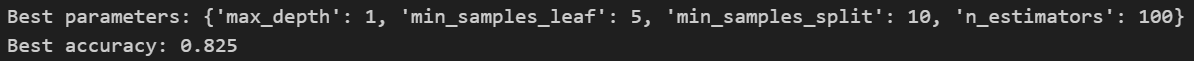

MLP

In [2]:
# Transform data sets into tensors
x_test_tensor = torch.tensor(x_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)
x_train_tensor = torch.tensor(x_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)

# Create MLP model
model_MLP = MLP_enzymes()

# Train model
train_mlp(model_MLP, x_train_tensor, y_train_tensor)

# Set model to evaluate
model_MLP.eval()


with torch.no_grad():
    # Get predicted value
    y_predict_MLP = model_MLP(x_test_tensor)

# If predict >0.5 turn it into 1.0 (enzyme), if not turn it into 0.0(not-enzyme)
_, predicted_results = torch.max(y_predict_MLP, 1)

# Transform predicted values to numpy
y_predict_classes_npy = predicted_results.cpu().numpy()

# Get evaluation metrics of MLP model
accuracy_MLP, f1_MLP, conf_matrix_MLP = evaluation_metrics(y_test, y_predict_classes_npy)

Epoch 20/1000, Loss 1.4474
Epoch 40/1000, Loss 0.9383
Epoch 60/1000, Loss 0.5687
Epoch 80/1000, Loss 0.3398
Epoch 100/1000, Loss 0.1960
Epoch 120/1000, Loss 0.1101
Epoch 140/1000, Loss 0.0761
Epoch 160/1000, Loss 0.0440
Epoch 180/1000, Loss 0.0355
Epoch 200/1000, Loss 0.0314
Epoch 220/1000, Loss 0.0291
Epoch 240/1000, Loss 0.0286
Epoch 260/1000, Loss 0.0286
Epoch 280/1000, Loss 0.0311
Epoch 300/1000, Loss 0.0252
Epoch 320/1000, Loss 0.0246
Epoch 340/1000, Loss 0.0259
Epoch 360/1000, Loss 0.0258
Epoch 380/1000, Loss 0.0286
Epoch 400/1000, Loss 0.0292
Epoch 420/1000, Loss 0.0230
Epoch 440/1000, Loss 0.0237
Epoch 460/1000, Loss 0.0243
Epoch 480/1000, Loss 0.0230


KeyboardInterrupt: 

Results

EC
2    64
1    64
4    64
7    64
5    64
0    64
3    64
6    64
Name: count, dtype: int64
---------- MLP ----------
Accuracy 0.7031
F1 Score 0.7054
[[13  0  1  1  0  0  0  1]
 [ 0 13  1  0  1  0  1  0]
 [ 2  0  7  3  1  1  0  2]
 [ 1  0  5  8  1  0  0  1]
 [ 0  0  1  1  9  5  0  0]
 [ 0  0  2  0  1 13  0  0]
 [ 0  0  2  0  0  0 13  1]
 [ 2  0  0  0  0  0  0 14]]


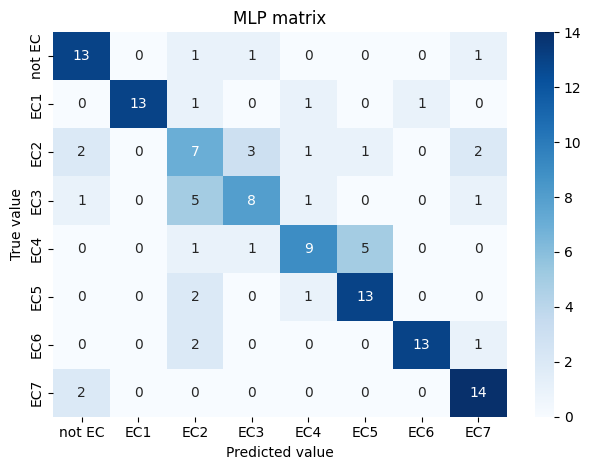

In [3]:
print(y_train.value_counts())

# Create subplots
fig, ax = plt.subplots()

# Print evaluation metrics of MLP
print("---------- MLP ----------")
print(f"Accuracy {accuracy_MLP:.4f}")
print(f"F1 Score {f1_MLP:.4f}")
print(f"{conf_matrix_MLP}")

# Create MLP heatmap of conf_matrix
sns.heatmap(conf_matrix_MLP, annot=True, fmt='d', cmap='Blues',
            xticklabels=['not EC', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'EC7'], yticklabels=['not EC', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'EC7'],
            ax=ax)
ax.set_title('MLP matrix')
ax.set_ylabel('True value')
ax.set_xlabel('Predicted value')

# Print heatmaps
plt.tight_layout()
plt.show()

Save MLP model

In [ ]:
path_to_model = 'model/enzymes_MLP.pth'
torch.save(model_MLP.state_dict(), path_to_model)